# Classification
Regression algorithms predict values whereas classification algorithms predicts classes.
### MNIST
MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labelled with the digit it represents. The MNIST dataset is like the "Hello World" of classification algorithms.

Scikit-Learn has many helper functions to download popular datasets and MNIST is one of them. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have similar dictionary structure including:
- A _DESCR_ key describing the dataset
- A _data_ key containing an array with one row per instance and one column per feature
- A _target_ key containing an array with the labels

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features. This is because each image is 28x28 pixels and each feature represents the pixel's intensity from 0 (white) to 255 (black). To look at one digit in the dataset, grab an instance's feature vector, reshape it into a 28x28 array and plot it using matplotlib's imshow().

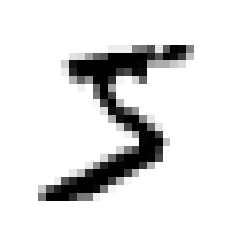

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
#To confirm that the image shows a 5 by checking the label for this image
y[0]

'5'

In [6]:
#The label is given as a string, it is more convenient to cast y into integers
import numpy as np
y = y.astype(np.uint8)

In [7]:
#Split the dataset into test set and train set (60,000 to train and 10,000 to test)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier
To simplify the problem start by identifying the number 5 only. This is an example of a _Binary Classifier_ where the model can only distinguish between 5 or not 5. To create the target vectors for this classification task:

In [8]:
y_train_5 = (y_train == 5) #True for all 5s and False otherwise
y_test_5 = (y_test == 5)

A good classifier to start with is a _Stochastic Gradient Descent_ (SGD) classifier using Scikit-Learn's SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. SGD deals with training instances independently, one at a time.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

#To check if the model can detect the number 5 on one particular example
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures
Evaulating a classifier is significantly more difficult than evaluating a regressor. 

One good way to evaluate a model is to use cross-validation. Sometimes more control over the cross-validation process is needed other than the cross_val_score() provided off the shelf. For example, StratifiedKFold so each fold contains a representative ratio of each class. It then counts the number of correct predictions and outputs and prints the ratio of correct predictions.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Normal cross_val_score() splits the training set into k folds (in this case 3) and then makes predictions and evaluates the model on each fold while training the model on the remaining folds.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

While measuring the accuracy of the model gives a score of 95%+, it is not a good measure of performance as 10% of the images are 5s then guessing that every image is not a 5 will be correct 90% of the time as shown in the next example.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

A much better way to evaluate performance is to use a _confusion matrix_ approach. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier has confused images of 5s with 3s, it would be the 5th row and the 3rd column of the confusion matrix.

To compute the confusion matrix, the first step is to have a set of predictions so they can be compared to the actual targets. Predictions can be made on the test set but it is better kept for the final version of the model. Instead, use the cross_val_predict() function:

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation but instead of returning the evaluation scores it returns the predictions made on each test fold.

The following code computes the confusion matrix using the confusion_matrix() function. Pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an _actual class_ while each column represents a _predicted class_. 

The first row of the matrix considers non-5 images (_negative class_): 53,892 of them were correctly classified as non-5s (known as _true negatives_) while the remaining 687 were wrongly classified as 5s (_false positives_).

The second row considers the images of 5s (_positive class_): 1891 were wrongly classified as non-5s (_false negatives_) while the remaining 3530 were classified as 5s (_true positive_). A perfect classifier will only have true positives and true negatives.

In [15]:
y_train_perfect_predictions = y_train_5 #pretend we have reached a perfect classifier
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives a lot of information but sometimes a more concise metric is needed. An interesting metric is the accuracy of positive predictions called the _precision_ of a classifier.
$$ precision = \frac {TP}{TP+FP} $$

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This is not useful as the classifier would ignore all but one positive instance. So, precision is typically used along with another metric named _recall_, also called _sensitivity_ or _true positive rate_ (TPR): the ratio of positive instances that are correctly detected by the classifier.
$$ recall = \frac {TP}{TP+FN} $$
Where FN is the number of false negatives.

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics including precision and recall:

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530+687)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530+1891)

0.6511713705958311

When the model claims an image represents a 5, it is correct 83.7% of the time. It also only detects 65.1% of 5s.

It is often convenient to combine the precision and recall metric into a single metric called the $F_{1}$ score that is useful in comparing the performance of two classifiers. The $F_{1}$ score is the _harmonic mean_ of precision and recall. While the normal average treats all values equally, the harmonic mean gives more weight to low values so the classifier will only get a high $F_{1}$ score if both recall and precision are high. $$F_{1}=\frac{2}{({\frac{1}{precision}+\frac{1}{recall}})}=2 \times \frac{precision \times recall}{precision + recall}= \frac{TP}{TP + \frac{FN+FP}{2}}$$

In [18]:
#Compute the F_1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_{1}$ score favors classifiers that have similar precision and recall. This is not always what is wanted as illustrated by the two following scenarios:
1. If training a classifier to detect videos that are not safe for kids, low recall but high precision is probably preferred, i.e. the classifier rejects many good videos (low recall) but keeps only safe ones (high precision) instead of occasionally letting some bad videos through (high $F_{1}$)
2. To detect shoplifters in surveillance videos low precision but high recall is more appropriate, i.e. there will be a few false alerts but almost all shoplifters will be caught.

### Precision/Recall Tradeoff
Increasing precision reduces recall and vice versa called the _precision recall tradeoff_. To understand this tradeoff look at how the SGDClassifier makes decisions, it computes a score based on a _decision function_ and if that score is above a threshold, it assigns the instance to the positive class or else it assigns it to the negative class.

Figure 3.3 shows some digits positioned from the lowest scroes to the highest from left to right, the different arrows represents different thresholds. Suppose the decision threshold is the middle arrow, the precision is 4/5 (80%) with 4 true positives and 1 false positive. Raising the threshold (moving it to the right), the false positive (the 6) becomes a true negative therefore increasing precision to 100% but one true positive becomes a false negative decreasing recall to 50%. Lowering the threshold has the opposite effect of increasing recall and reducing precision.

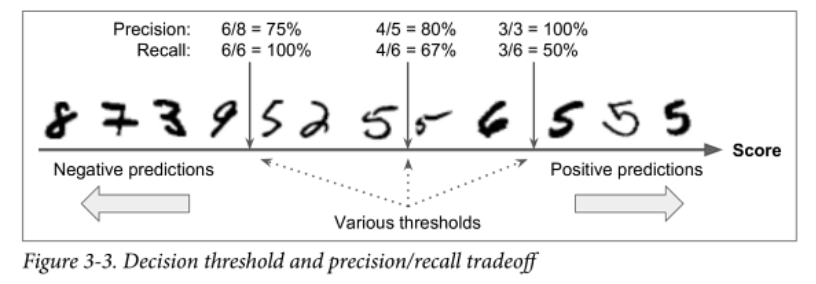

Scikit-Learn doesn't allow the user to specify the threshold directly but it does give access to decision scores by using the classifier's decision_function() method, which returns a score for each instance then makes a prediction based on the scores using any threshold set by he user

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
#SGDClassifier uses threshold = 0 so the result above is same as the predict() method. To raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

As shown here, raising the threshold will decrease recall. The image represents a 5 but the classifier misses it if the threshold is set to 8000 instead of keeping it at the default 0.

To decide which threshold to use, calculate scores for all instances in the training set using cross_val_predict() function but specify the function to return scores instead of predictions:

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, it is possible to compute precision and recall for all possible thresholds using the precision_recall_curve() function. And the results (precision and recall) can be plotted against the threshold value using Matplotlib

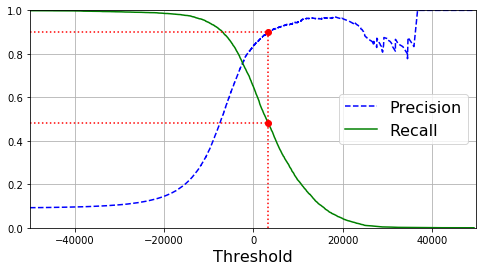

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

Side note on the shape of the curve: the precision curve is bumpier because it can go down when threshold increases (although it will generally go up) whereas recall can only go down as the threshold increases.

Suppose 90% precision is the target and from the plot, it shows that this can be achieved at a threshold of about 3370. To be more precise, search for the lowest threshold value that gives at least 90% precision (np.argmax() will give the first index of the maximum value, which means the first True value):

In [24]:
#threshold_90_precision = threshold[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [25]:
#Instead of running the predict() method, run
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [26]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Note that a high precision classifier is not that useful if the recall is too low.

### The ROC Curve
The _receiver operating characteristic_ (ROC) curve is another common tool used with binary classifiers. It is similar to the precision/recall curve but instead of plotting precision vs recall, the ROC curve plots _true positive rate_ (recall) against the _false positive rate_. The FPR is the ratio of negative instances that are incorrectly classified as positive and is equal to one minus the _true negative rate_, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called the _specificity_ hence the ROC curve plots _sensitivity_ (recall) against $1 - specificity$.

To plot the ROC curve, compute the TPR and FPR for various threshold values using roc_curve() function:

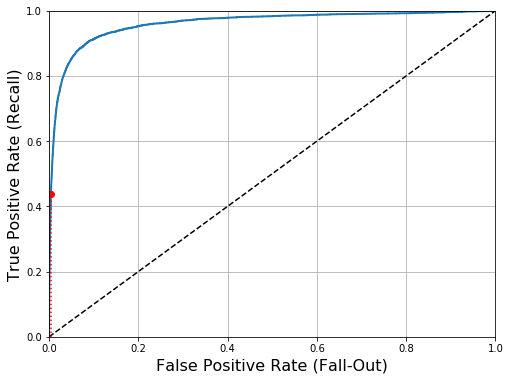

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#Plot FPR against TPR using Matplotlib
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier and a good classifier will stay away from the line towards the top left corner.

One way to compare classifiers is to measure the _area under the curve_ (AUC). A perfect classifier will have a ROG AUC of 1， whereas a purely random classifier will have a ROG AUC of 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Use the PR curve whenever positive class cases are rare or when false positives are more important than false negatives and use the ROC curve otherwise. For the case of a binary classifier, the ROC AUC curve shows that it is a really good classifier because there are few positives and many negatives. However, the PR curve shows that there is room for improvement (the curve could be closer to the top right corner).

Train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, get scores for each instance in the training set, but due to the way it works, the RandomForestClassifier class does not have a decision_function(). Instead it has a predict_proba() method. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that a given instance belongs to the given class (70% chance that the image represents a 5):

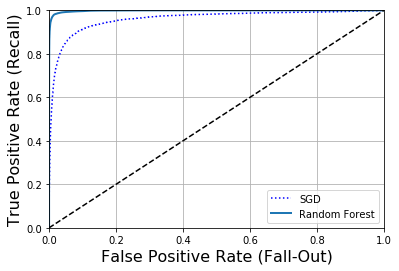

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

#Plot positive class probabilities as scores
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

#Plot the first ROC curve as well to compare the classifiers
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
#Compute ROC AUC for the random forest classifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification
Multiclass classifiers can distinguish between more than two classes. Some algorithms such as Random Forest classifier or naive Bayes classifiers are capable of handling multiple classes directly. Others like Support Vector Machines and Linear classifiers are strictly binary classifiers. However, there are various strategies to perform multiclass classification using multiple binary classifiers.

For example, 10 binary classifiers can be trained to sort digit images into 10 classes (0 to 9) with one classifier for each digit. When classifying the digit, compute the decision score from each classifier and for that image select that classifier that outputs the highest score, this method is known as _one versus all_ (OVA) strategy.

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another for 0s and 2s, another for 1s and 2s and so on. This is the _one versus one_ strategy. If there are N classes, then $\frac {N\times(N-1)}{2}$ classifiers are needed, so the MNIST dataset would need 45 classifiers, the image then would have to run through all classifiers to see which class scores the highest. The advantage of OvO strategies is that the classifier only needs to be trained on the part of the training set for the two classes it needs to distinguish.

Some algorithms like the Support Vector Machine classifier scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets rather than training few classifiers on large training sets. For most binary classifier algorithms, OvA is preferred.

Scikit-Learn detects when a binary classification algorithm is used for a multiclass classification task, and it will automatically run OvA (except for SVMs in which it would run OvO). To try this on the SGDClassifier:

In [32]:
sgd_clf.fit(X_train, y_train) #note it is y_train not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In the background, Scikit-Learn trained 10 binary classifiers and got their decision scores of the image. It then selected the class with the highest score. The decision_function() method returns 10 scores, one per class, to illustrate this point

In [33]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [34]:
#The highest score in this case corresponds to the class 3 which is incorrect because the image is from class 5
np.argmax(some_digit_score)

3

In [35]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [36]:
sgd_clf.classes_[5]

5

To force Scikit-Learn to use OvO or OvA strategy, the OneVsOneClassifier or OneVsRestClassifier classes can be used. Create an instance and pass a binary classifier to its constructor. The following code creates a multi-class classifier using the OvO strategy based on a SGDClassifier:

In [37]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
#To train a RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit-Learn did not have to run OvA or OvO because Random Forest Classifiers can directly classify instances into multiple classes. Call predict_proba() to get the list of probabilities that the classifier assigned to each instance of each class:

In [40]:
forest_clf.predict_proba([some_digit]) #The classifier predicts a 5 with 90% probability 

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

To evaluate the classifiers, use cross-validation. Using the cross_val_score() function on SGDClassifier to compute accuracy:

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

The classifier gets over 85% on all test folds. For a random classifier, the accuracy would be 10%. However, the model can still do better. By scaling the inputs to have a mean centred at 0, the accuracy can be improved to above 89%.

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis
To find ways to improve the model, the errors made by the model has to be analysed. The first thing to look at is the confusion matrix. To compute this, make predictions using cross_val_predict() function, then call the confusion_matrix() function:

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

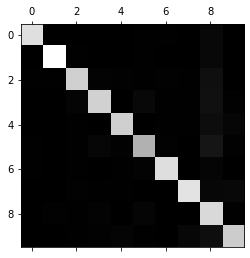

In [44]:
#Representing the confusion matrix as an image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Since most images are on the main diagonal, the classification was mostly correct. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. To verify that both are the case, plot the errors by dividing each value in the confusion matrix by the number of images in the corresponding class to compare the error rates instead of the absolute error

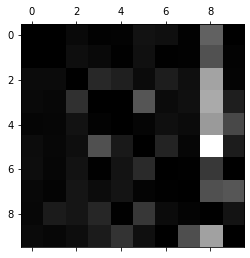

In [45]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
#Fill the diagonals with zeros and only keep the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent the actual classes while columns represent the predicted classes. The column for 8 is quite bright meaning that many images get misclassified as 8s. However, the row of 8 is quite dark meaning that in general actual 8s are correctly classified. The confusion matrix is not necessarily symmetrical. 3 and 5 are also often confused in both directions.

To improve the classifier, some effort should be spent on reducing the false 8s. Try to gather more training data for digits that look like 8s (but are not) so the classifier can distinguish them from real 8s. Alternatively, a new feature can be engineered that would help the classifier like writing an algorithm to count the number of closed loops (8 has two, 6 has one, etc.). The image can also be pre-processed to make patterns stand out more like closed loops.

Analysing individual errors can also pinpoint why the classifier is failing. For example, consider the 3s and 5s using plot_digits() function.

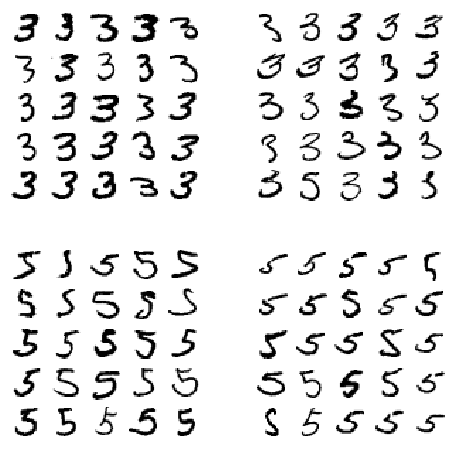

In [46]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s and the two 5x5 blocks on the right shows images classified as 5s. While some mistakes are understandable, the classifier still makes mistakes that are obviously wrong. The reason is that the classifier is a SGDClassifier, which is a linear model. It assigns a weight per class to each pixel and sums up the weighted pixel intensities to get a score for each class. Since 3s and 5s only differ by a few pixels, the model can easily confuse them.

The difference between and 3 and a 5 is the position of the small line that joins the top line and the bottom arc. Shifting the junction of the 3 slightly to the left the classifier might classify it as a 5 and vice versa. The classifier is sensitive to image shifting and rotation. One way to improve the model might be to pre-process the image such that all images are well centered and not too rotated.

### Multilabel Classification
Right now each instance has always been assigned to just one class. In some cases, it might be useful to output multiple classes for each instance. For example, for a face recognition algorithm, if it needs to recognize several people on the same picture, it should attach one tag per person it recognises. If the classifier is trained to recognise Alice, Bob and Charlie and only Alice and Charlie are in the picture, the output should be [1,0,1]. These classifiers that output multiple binary tags are known as _multilabel classifiers_.

The following code creates a y_multilabel array containing two target labels for each digit image: 
1. Indicates whether the digit is large (7, 8 or 9)
2. Indicates whether it is odd

In [48]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit]) # 5 is not large and odd. Expected output: [False, True]

array([[False,  True]])

One way to evaluate the model is to compute the $F_{1}$ score for each individual label (or any other binary classifier metric) and compute the average score. To compute the average $F_{1}$ score:

In [49]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important. For example, if there are more pictures of Alice than Bob or Charlie, the classifier's score on Alice's pictures should have more weight. One simple option is to give each label a weight to its support (i.e. number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

### Multioutput Classification
_Multioutput multiclass classification_ is a multilabel classification where each label can be multiclass (i.e. can have more than two values). 

An example would be removing noise from images. The input would be a noisy digit image and hopefully it will output a clean digit image represented by an array of pixel intensities just like the MNIST images. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranging from 0 to 255).

Start by adding noise to the test sets by using np.randint() on the pixel intensities function. 

In [50]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mode = X_test #The labels are the original images in the MNIST data set without noise

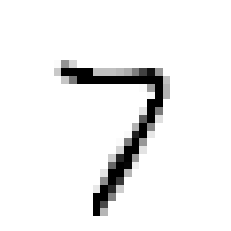

In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)